In [1]:
# Import necessary libraries

#!pip install pyspark
#!pip install nltk
#!pip install matplotlib
#!pip install kaggle

import os
import zipfile

import nltk
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import col, lower, regexp_replace, trim, rand, udf, size
from pyspark.sql.types import ArrayType, StringType, BooleanType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, MinHashLSH
from pyspark.sql.functions import monotonically_increasing_id


nltk.download('stopwords')

print("All libraries imported successfully.")

All libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karankooshavar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# download the dataset from Kaggle if not already present

csv_file = 'Books_rating.csv'
zip_file = 'amazon-books-reviews.zip'

# download and unzip if the final CSV file does not exist

if not os.path.exists(csv_file):

    os.environ['KAGGLE_USERNAME'] = "xxxxxx"
    os.environ['KAGGLE_KEY'] = "xxxxxx"

    !kaggle datasets download -d mohamedbakhet/amazon-books-reviews

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded and unzipped successfully.")

    os.remove(zip_file)

else:
    print(f"'{csv_file}' already exists. Skipping download and unzip.")

'Books_rating.csv' already exists. Skipping download and unzip.


In [3]:
# Initialize Spark session
# Set the Spark application name and memory configuration

spark = SparkSession.builder \
    .appName("BookReviewSimilarity") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/06 14:59:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:


# loading dataset
DATA_PATH = "Books_rating.csv"
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# specifying the sample size(to be filled manually)
df = df.orderBy(rand(seed=42)).limit(50000)

print(f"Using a sample of {df.count()} rows.")



Using a sample of 50000 rows.


In [ ]:
#cleaning the dataset

df = df.na.drop(subset=["Title", "review/text"])

# cleaning Title column

df = df.withColumn('clean_title', lower(col('Title')))
df = df.withColumn('clean_title', regexp_replace('clean_title', r'[^a-z0-9\s]', ''))
df = df.withColumn('clean_title', regexp_replace('clean_title', r'\\s+', ' '))
df = df.withColumn('clean_title', trim(col('clean_title')))


# cleaning Review Text
df = df.withColumn('clean_text', lower(col('review/text')))
df = df.withColumn('clean_text', regexp_replace('clean_text', r'[^a-z\s]', ''))
df = df.withColumn('clean_text', trim(col('clean_text')))


In [6]:
# remove reviews that are only numbers and spaces

print(f"Rows before number-only review filtering: {df.count()}")


df = df.filter(~col("clean_text").rlike("^[\\d\\s]*$"))

print(f"Rows after number-only review filtering: {df.count()}")

Rows before number-only review filtering: 49997


Rows after number-only review filtering: 49923


In [7]:
# tokenize text using Spark's Tokenizer

tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
df = tokenizer.transform(df)

# remove stopwords

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# stemming 

ps = PorterStemmer()
def stem_text(words):
    if not words:
        return []
    return [ps.stem(word) for word in words]

stem_udf = udf(stem_text, ArrayType(StringType()))
df = df.withColumn("tokens", stem_udf(col("filtered_words")))


25/07/06 14:59:57 WARN StopWordsRemover: Default locale set was [en_IT]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [8]:
# Add a unique identifier to each review row. This is crucial for the self-join later.
df = df.withColumn("review_id", monotonically_increasing_id())

print("Added unique 'review_id' to each row.")

Added unique 'review_id' to each row.


In [9]:

# vectorize the final tokens using CountVectorizer

# removing empty token lists
df = df.filter(size(col('tokens')) > 0)

# vectorize tokens
cv = CountVectorizer(inputCol="tokens", outputCol="features", minDF=2, vocabSize=10000) # Added vocabSize limit
df = cv.fit(df).transform(df)

# function to find zero-vectors (minhash won't work with zero-vectors)

def has_nonzero(v):
    return v is not None and v.numNonzeros() > 0
has_nonzero_udf = udf(has_nonzero, BooleanType())

# remove the found zero-vectors, caching the result

df_clean = df.filter(has_nonzero_udf(col("features"))).persist(StorageLevel.MEMORY_AND_DISK)

print("Rows after strict zero-vector filtering:", df_clean.count())

Rows after strict zero-vector filtering: 49910


In [10]:
# train the LSH model

minhash = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=20)
model = minhash.fit(df_clean)
df_hashed = model.transform(df_clean)

# similarity join

JACCARD_DISTANCE = 0.6

print(f"\nFinding pairs with Jaccard Distance less than {JACCARD_DISTANCE:.2f}...")

# find similar pairs using the LSH model and filtering not to include self-joins and duplicate pairs

candidate_pairs = model.approxSimilarityJoin(
    df_hashed, df_hashed, JACCARD_DISTANCE, distCol="JaccardDistance"
).filter(col("datasetA.review_id") < col("datasetB.review_id")).cache()

print(f"Pairs with Jaccard Distance less than 0.6 ({candidate_pairs.count()} rows) DataFrame is ready.")


Finding pairs with Jaccard Distance less than 0.60...


25/07/06 15:01:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Pairs with Jaccard Distance less than 0.6 (2078 rows) DataFrame is ready.


In [11]:

# tokenize the titles to compare their sets of words

title_tokenizer = Tokenizer(outputCol="title_tokens")
tokenized_pairs = title_tokenizer.setInputCol("datasetA.clean_title").transform(candidate_pairs).withColumnRenamed("title_tokens", "title_A_tokens")
tokenized_pairs = title_tokenizer.setInputCol("datasetB.clean_title").transform(tokenized_pairs).withColumnRenamed("title_tokens", "title_B_tokens")

# define and apply a function to check for the subset relationship

def is_subset(list1, list2):
    if not list1 or not list2:
        return False
    set1 = set(list1)
    set2 = set(list2)
    return set1.issubset(set2) or set2.issubset(set1)

is_subset_udf = udf(is_subset, BooleanType())
subset_pairs = tokenized_pairs.withColumn("is_subset_title", is_subset_udf(col("title_A_tokens"), col("title_B_tokens")))


In [12]:
# the final filters

# Filter 1: remove pairs where reviews are identical AND the title is a subset.

almost_final_pairs = subset_pairs.filter(
    (col("JaccardDistance") > 0.0) |
    (col("is_subset_title") == False)
)

# Filter 2: remove pairs where reviews are identical AND from the same user.
final_pairs = almost_final_pairs.filter(
    (col("JaccardDistance") > 0.0) |
    (col("datasetA.User_id") != col("datasetB.User_id"))
).cache()


print(f"Final filtering complete. The 'final_pairs'({final_pairs.count()} rows) DataFrame is ready.")

Final filtering complete. The 'final_pairs'(1170 rows) DataFrame is ready.


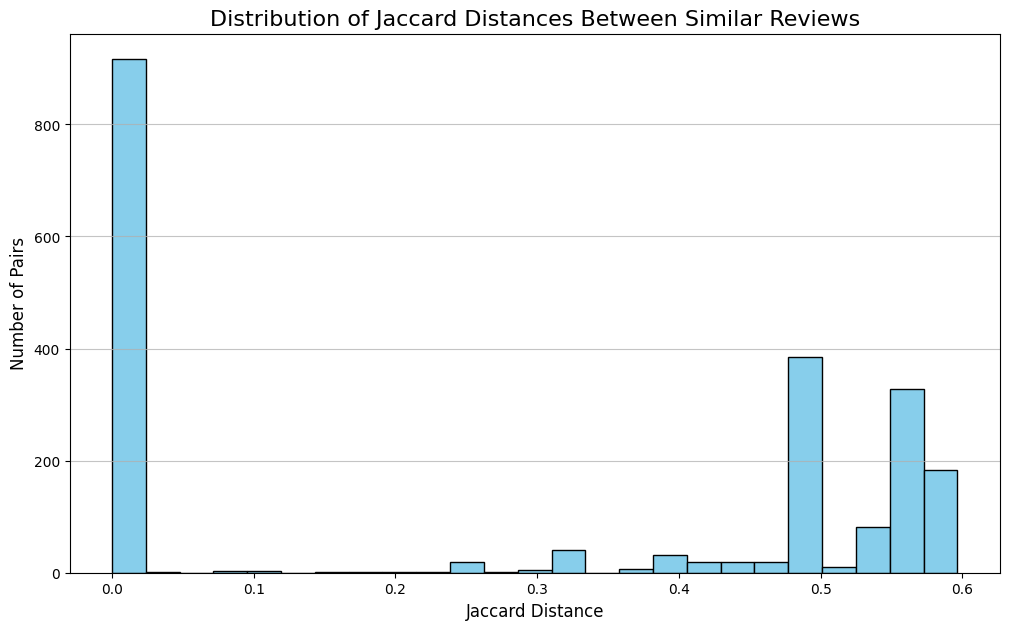

In [13]:
# visualize preliminary results distribution

jaccard_distances_pd1 = candidate_pairs.select("JaccardDistance").toPandas()

plt.figure(figsize=(12, 7))
plt.hist(jaccard_distances_pd1['JaccardDistance'], bins=25, color='skyblue', edgecolor='black')

plt.title('Distribution of Jaccard Distances Between Similar Reviews', fontsize=16)
plt.xlabel('Jaccard Distance', fontsize=12)
plt.ylabel('Number of Pairs', fontsize=12)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [14]:
# show final filtered pairs

interesting_duplicates = subset_pairs.filter(
    (col("JaccardDistance") == 0.0) &
    (col("is_subset_title") == True) &
    (col("datasetA.clean_title") != col("datasetB.clean_title"))
)

interesting_duplicates.select(
    col("datasetA.clean_title").alias("Title_A"),
    col("datasetB.clean_title").alias("Title_B"),
    "is_subset_title",
    "JaccardDistance"
).show(20, truncate=False)


+-------------------------------------------------------------------------------+-----------------------------------------------------------+---------------+---------------+
|Title_A                                                                        |Title_B                                                    |is_subset_title|JaccardDistance|
+-------------------------------------------------------------------------------+-----------------------------------------------------------+---------------+---------------+
|of mice and men penguin audiobooks                                             |of mice and men                                            |true           |0.0            |
|little women or meg jo beth and amy parts i and ii                             |little women or meg jo beth and amy                        |true           |0.0            |
|little women or meg jo beth and amy                                            |little women or meg jo beth and amy parts i and i

In [15]:
# display the final, clean results, sorted by the least similar pairs first

print("\nShowing top candidate pairs found (sorted by least similar first):")

final_pairs.select(
    col("datasetA.clean_title").alias("Title_A"),
    col("datasetB.clean_title").alias("Title_B"),
    col("datasetA.User_id").alias("User_ID_A"),
    col("datasetB.User_id").alias("User_ID_B"),
    col("datasetA.review/text").alias("Original_Review_A"),
    col("datasetB.review/text").alias("Original_Review_B"),
    "JaccardDistance"
).orderBy(col("JaccardDistance").desc()).show(20, truncate=60)


Showing top candidate pairs found (sorted by least similar first):
+------------------------------------------------------------+------------------------------------------------------------+--------------+--------------+------------------------------------------------------------+------------------------------------------------------------+------------------+
|                                                     Title_A|                                                     Title_B|     User_ID_A|     User_ID_B|                                           Original_Review_A|                                           Original_Review_B|   JaccardDistance|
+------------------------------------------------------------+------------------------------------------------------------+--------------+--------------+------------------------------------------------------------+------------------------------------------------------------+------------------+
|la desaparicion del universo the disappearance

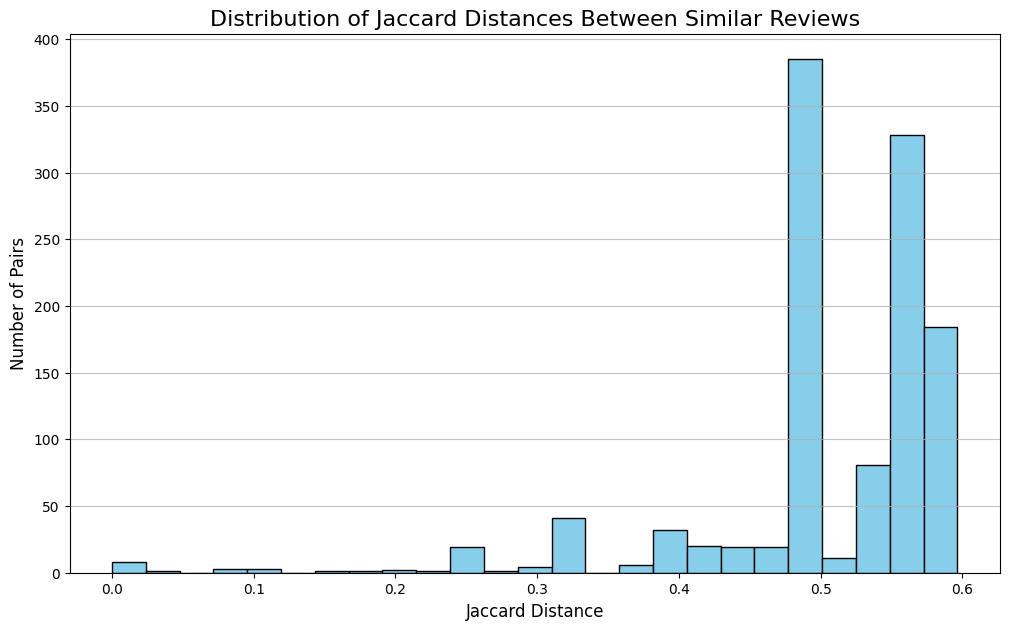

In [ ]:
# visualize final results distribution

jaccard_distances_pd = final_pairs.select("JaccardDistance").toPandas()

plt.figure(figsize=(12, 7))
plt.hist(jaccard_distances_pd['JaccardDistance'], bins=25, color='skyblue', edgecolor='black')

plt.title('Distribution of Jaccard Distances Between Similar Reviews', fontsize=16)
plt.xlabel('Jaccard Distance', fontsize=12)
plt.ylabel('Number of Pairs', fontsize=12)
plt.grid(axis='y', alpha=0.75)

plt.show()

In [17]:
# emopty the memory and disk

df_clean.unpersist()
final_pairs.unpersist()
df_clean.unpersist()

print("\nProcessing complete.")


Processing complete.
